In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import sqrt
from math import ceil, log2
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider


In [2]:
is_using_IBM = False
TOKEN = ''


simulator = AerSimulator()
if is_using_IBM:
    provider = IBMProvider(token=TOKEN)
    simulator = provider.get_backend("ibm_nairobi")
print(simulator)


aer_simulator


In [3]:
### Utility functions ###

# Transform a binary number to 2s compliment
def to_2scompliment(num):
    number = 0
    for i in reversed(range(len(num))):
        int_num = int(num[i])
        if int_num == 1:
            power = 2**(len(num)-i-1)
            if i == 0:
                number -= int_num*power
            else:
                number += int_num*power
    return number

# Transform counts object to have 2s compliment keys
def transform_to_2scompliment(counts):
    new_object = {}
    for key in counts.keys():
        new_object[to_2scompliment(key)] = counts[key]
    return new_object

In [4]:
# Left step transition (binary subtraction by 1)
def left_step_transition(circuit, total_num_bits, use_different_circuit=True):
    unitary_circuit = circuit
    if use_different_circuit:
        unitary_circuit = QuantumCircuit(total_num_bits, name='left_step_transition')
    # Build the circuit        
    for i in range(1, total_num_bits):
        unitary_circuit.mct([j for j in range(i)], i)
    if use_different_circuit:
        circuit.append(unitary_circuit, range(total_num_bits))

# Right step transition (binary addition by 1)
def right_step_transition(circuit, total_num_bits, use_different_circuit=True):
    unitary_circuit = circuit
    if use_different_circuit:
        unitary_circuit = QuantumCircuit(total_num_bits, name='left_step_transition')
    # Build the circuit
    for i in range(1, total_num_bits):
        unitary_circuit.mct([j for j in range(i)], i)
        if i == total_num_bits - 1:
            for j in range(i):
                unitary_circuit.x(j)
        else:
            unitary_circuit.x(i)
    if use_different_circuit:
        circuit.append(unitary_circuit, range(total_num_bits))

In [5]:
def set_up_initial_state(circuit, init_state):

    for i in range(len(init_state)):
        if init_state[i] == 1:
            circuit.x(i + 1)


def add_unitary_decision(circuit, total_num_bits, use_different_circuit=True):
    unitary_circuit = circuit
    if use_different_circuit:
        unitary_circuit = QuantumCircuit(total_num_bits, name='add_unitary_decision')
    ### Build the circuit ###
    unitary_circuit.barrier()
    left_step_transition(unitary_circuit, total_num_bits, use_different_circuit)
    unitary_circuit.x(0)
    right_step_transition(unitary_circuit, total_num_bits, use_different_circuit)
    unitary_circuit.barrier()
    ### End of build the circuit ###
    if use_different_circuit:
        circuit.append(unitary_circuit, range(total_num_bits))
        
    

In [6]:

# Balanced coin
Y_matrix = [
    [1/sqrt(2), 1j/sqrt(2)],
    [1j/sqrt(2), 1/sqrt(2)]
]
Y_gate = Operator(Y_matrix)

# Sets up the initial state of the coin
# to go either right, left or a balanced version
def init_state(circuit, direction):
    if direction == 'go_left':
        circuit.x(0)
    elif direction == 'balanced':
        circuit.s(0)
        circuit.h(0)


Total bits:  8
Circuit compiled


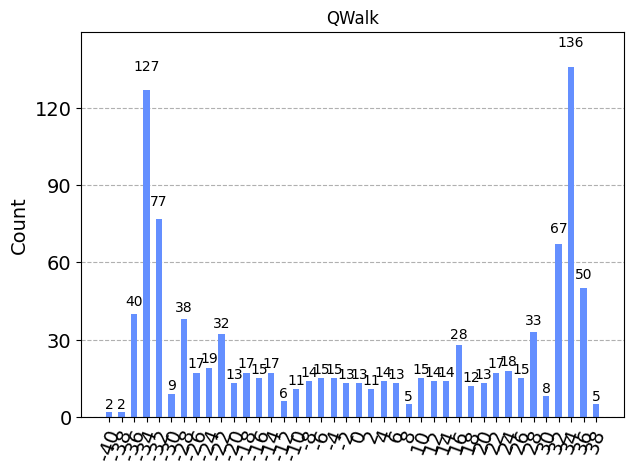

In [8]:
### Parameters ###
N = 100 # number of states
is_classical = False # if true, measure coin register after each step
coin_type = 'balanced' # 'balanced', 'go_left', 'go_right'

bits = ceil(log2(N))
bits_tot = bits + 1
steps = ceil(N/2)

print('Total bits: ', bits_tot)
middle_binary = list(map(int, bin(N//2).split('b')[1]))
zeros_binary = [0 for i in range(bits)]
# middle_binary.reverse() # transform to big eddian

coin_register = QuantumRegister(1, name='coin')
position_register = QuantumRegister(bits, name='position')
classical_register = ClassicalRegister(bits, name='output')

circuit = QuantumCircuit(coin_register, position_register, classical_register, name="QWalk");

balanced_action = lambda : circuit.unitary(Y_gate, 0, label='Y')
hadamard_action = lambda : circuit.h(0)


# set up coin
init_state(circuit, coin_type)
#choose coin action
coin_action = balanced_action if coin_type == 'balanced' else hadamard_action


# set up register
set_up_initial_state(circuit, zeros_binary)

# add unitary decisions
for i in range(steps):
    # if i != 0:
    coin_action()
    add_unitary_decision(circuit, bits_tot, False)
    if is_classical:
        circuit.measure(coin_register, classical_register)
    print('Step ', i + 1, ' done', end='\r')

circuit.barrier()
circuit.measure(position_register, classical_register)


compiled_circuit = transpile(circuit, simulator, optimization_level=3)
print('Circuit compiled', end='\r')
job = simulator.run(compiled_circuit, shots=1000)
print()
print('Job submitted', end='\r')
result = job.result()
counts = result.get_counts()


plot_histogram(transform_to_2scompliment(counts), title='QWalk')
# circuit.draw(output='mpl')

